In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tarfile import open
import random

In [2]:
# prompt: import drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
#@title Dataset preprocessing
tar = open("/content/drive/MyDrive/CINIC-10.tar.gz", "r:gz")
tar.extractall()
tar.close()

class CINIC10Dataset:
    def __init__(self, batch_size=64, root='.'):
        self.transform = transforms.Compose([transforms.ToTensor()])

        temp_dataset = datasets.ImageFolder(root=f'{root}/train', transform=self.transform)
        temp_loader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

        # Calculate mean,std
        mean, std = self.calculate_mean_std(temp_loader)

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        self.batch_size = batch_size

        # Load data
        self.train_dataset = datasets.ImageFolder(root=f'{root}/train', transform=self.transform)
        self.train_dataoader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

        self.valid_dataset = datasets.ImageFolder(root=f'{root}/valid', transform=self.transform)
        self.valid_dataoader = DataLoader(self.valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

        self.test_dataset = datasets.ImageFolder(root=f'{root}/test', transform=self.transform)
        self.test_dataoader = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    def calculate_mean_std(self, loader):
        mean = 0.0
        std = 0.0
        total_images_count = 0

        for images, _ in loader:
            batch_samples = images.size(0)
            images = images.view(batch_samples, images.size(1), -1)
            mean += images.mean(2).sum(0)
            std += images.std(2).sum(0)
            total_images_count += batch_samples

        mean /= total_images_count
        std /= total_images_count

        return mean, std

    def get_train_loader(self):
        return self.train_dataoader

    def get_valid_loader(self):
        return self.valid_dataoader

    def get_test_loader(self):
        return self.test_dataoader


root_path = '/content/'
dataset = CINIC10Dataset(batch_size=128, root=root_path)

In [4]:
#@title Training and evaluation functions
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    return val_loss / len(val_loader), accuracy

def plot_metrics_train(train_losses, model_name):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.title(f'{model_name} Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

def plot_metrics_validation(train_losses, val_accuracies, model_name):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title(f'{model_name} Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [5]:
#@title ResNet9 Adam

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        # Convolution layers with stride=1 and padding=1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection with stride=2
        self.skip = nn.Sequential()
        if in_channels != out_channels or stride != 1:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )

        # MaxPool layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        x = self.skip(x)

        out += x
        out = F.relu(out)

        out = self.pool(out)
        return out

class ResNet9(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet9, self).__init__()

        # Initial convolution block
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # First residual block
        self.res1 = ResidualBlock(128, 128)

        # Second residual block
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third residual block
        self.res2 = ResidualBlock(512, 512)

        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # Initial convolutions
        x = F.relu(self.bn1(self.conv1(x)))  # 32x32 -> 32x32
        x = F.relu(self.bn2(self.conv2(x)))  # 32x32 -> 32x32
        x = self.pool1(x)  # 32x32 -> 16x16

        # First residual block
        x = self.res1(x)  # 16x16 -> 8x8

        # Second residual block
        x = F.relu(self.bn3(self.conv3(x)))  # 8x8 -> 8x8
        x = F.relu(self.bn4(self.conv4(x)))  # 8x8 -> 8x8
        x = self.pool2(x)  # 8x8 -> 4x4

        # Third residual block
        x = self.res2(x)  # 4x4 -> 2x2

        x = self.avgpool(x)  # 2x2 -> 1x1
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

resnet9 = ResNet9().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(resnet9.parameters(), lr=0.001, betas=(0.9, 0.999))

num_epochs = 20
batch_size = 512

train_loader = dataset.get_train_loader()
valid_loader = dataset.get_valid_loader()
test_loader = dataset.get_test_loader()

In [6]:
#@title Adversarial IGSM attack
def igsm_attack(model, images, labels, epsilon=0.12, alpha=0.006, num_iterations=20):
    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)

    adv_images = images.clone().detach().requires_grad_(True)

    for i in range(num_iterations):
        outputs = model(adv_images)
        loss = F.cross_entropy(outputs, labels)

        loss.backward()

        with torch.no_grad():
            adv_images = images + alpha * adv_images.grad.sign()
            eta = torch.clamp(adv_images - images, min=-epsilon, max=epsilon)
            adv_images = torch.clamp(images + eta, min=0, max=1)

        adv_images = adv_images.detach().requires_grad_(True)

    return adv_images.detach()

def adversarial_train(model, train_loader, criterion, optimizer, device, num_epochs=10, replacement_ratio=0.75):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            nb_adv = int(np.ceil(replacement_ratio * data.shape[0]))
            adv_data = igsm_attack(model, data[:nb_adv], target[:nb_adv])

            data[:nb_adv] = adv_data

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss/len(train_loader):.4f}")

def evaluate(model, data_loader, attack=None):
    model.eval()
    correct = 0
    total = 0

    for data, target in data_loader:
        data, target = data.to(device), target.to(device)


        if attack:
            data = attack(model, data, target)


        with torch.no_grad():
            output = model(data)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    return 100. * correct / total

In [ ]:
#@title Results on original ResNet 9
resnet9 = ResNet9().to(device)
resnet9.load_state_dict(torch.load('/content/drive/MyDrive/resnet9_pretrained.pth'))

benign_acc = evaluate(resnet9, test_loader)
igsm_acc = evaluate(resnet9, test_loader, lambda m, x, y: igsm_attack(m, x, y))
print(f"No Defense - Benign Accuracy: {benign_acc:.2f}%, IGSM Attack Accuracy: {igsm_acc:.2f}%")

<ipython-input-7-97cc0141c803>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet9.load_state_dict(torch.load('/content/resnet9_pretrained.pth'))


No Defense - Benign Accuracy: 74.29%, IGSM Attack Accuracy: 32.61%


In [ ]:
#@title Training and results on Adversarial trained ResNet 9
resnet9 = ResNet9().to(device)
resnet9.load_state_dict(torch.load('/content/drive/MyDrive/resnet9_pretrained.pth'))

# Adversarial training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet9.parameters(), lr=0.001)
adversarial_train(resnet9, train_loader, criterion, optimizer, device, num_epochs=10)

torch.save(resnet9.state_dict(), '/content/drive/MyDrive/resnet9igsm_pretrained10.pth')

benign_acc_adv = evaluate(resnet9, test_loader)
igsm_acc_adv = evaluate(resnet9, test_loader, lambda m, x, y: igsm_attack(m, x, y))
print(f"After Adversarial Training - Benign Accuracy: {benign_acc_adv:.2f}%, IGSM Attack Accuracy: {igsm_acc_adv:.2f}%")

<ipython-input-7-63484aa8ca66>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet9.load_state_dict(torch.load('/content/drive/MyDrive/resnet9_pretrained.pth'))


Epoch [1/10] - Loss: 0.8403
Epoch [2/10] - Loss: 0.6096
Epoch [3/10] - Loss: 0.4669
Epoch [4/10] - Loss: 0.3554
Epoch [5/10] - Loss: 0.2635
Epoch [6/10] - Loss: 0.2091
Epoch [7/10] - Loss: 0.1751
Epoch [8/10] - Loss: 0.1418
Epoch [9/10] - Loss: 0.1227
Epoch [10/10] - Loss: 0.1100
After Adversarial Training - Benign Accuracy: 71.98%, IGSM Attack Accuracy: 54.17%


<ipython-input-11-6a1d9cd974b6>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet9o.load_state_dict(torch.load('/content/drive/MyDrive/resnet9_pretrained.pth'))
<ipyth

IGSM Attack Images Comparison:


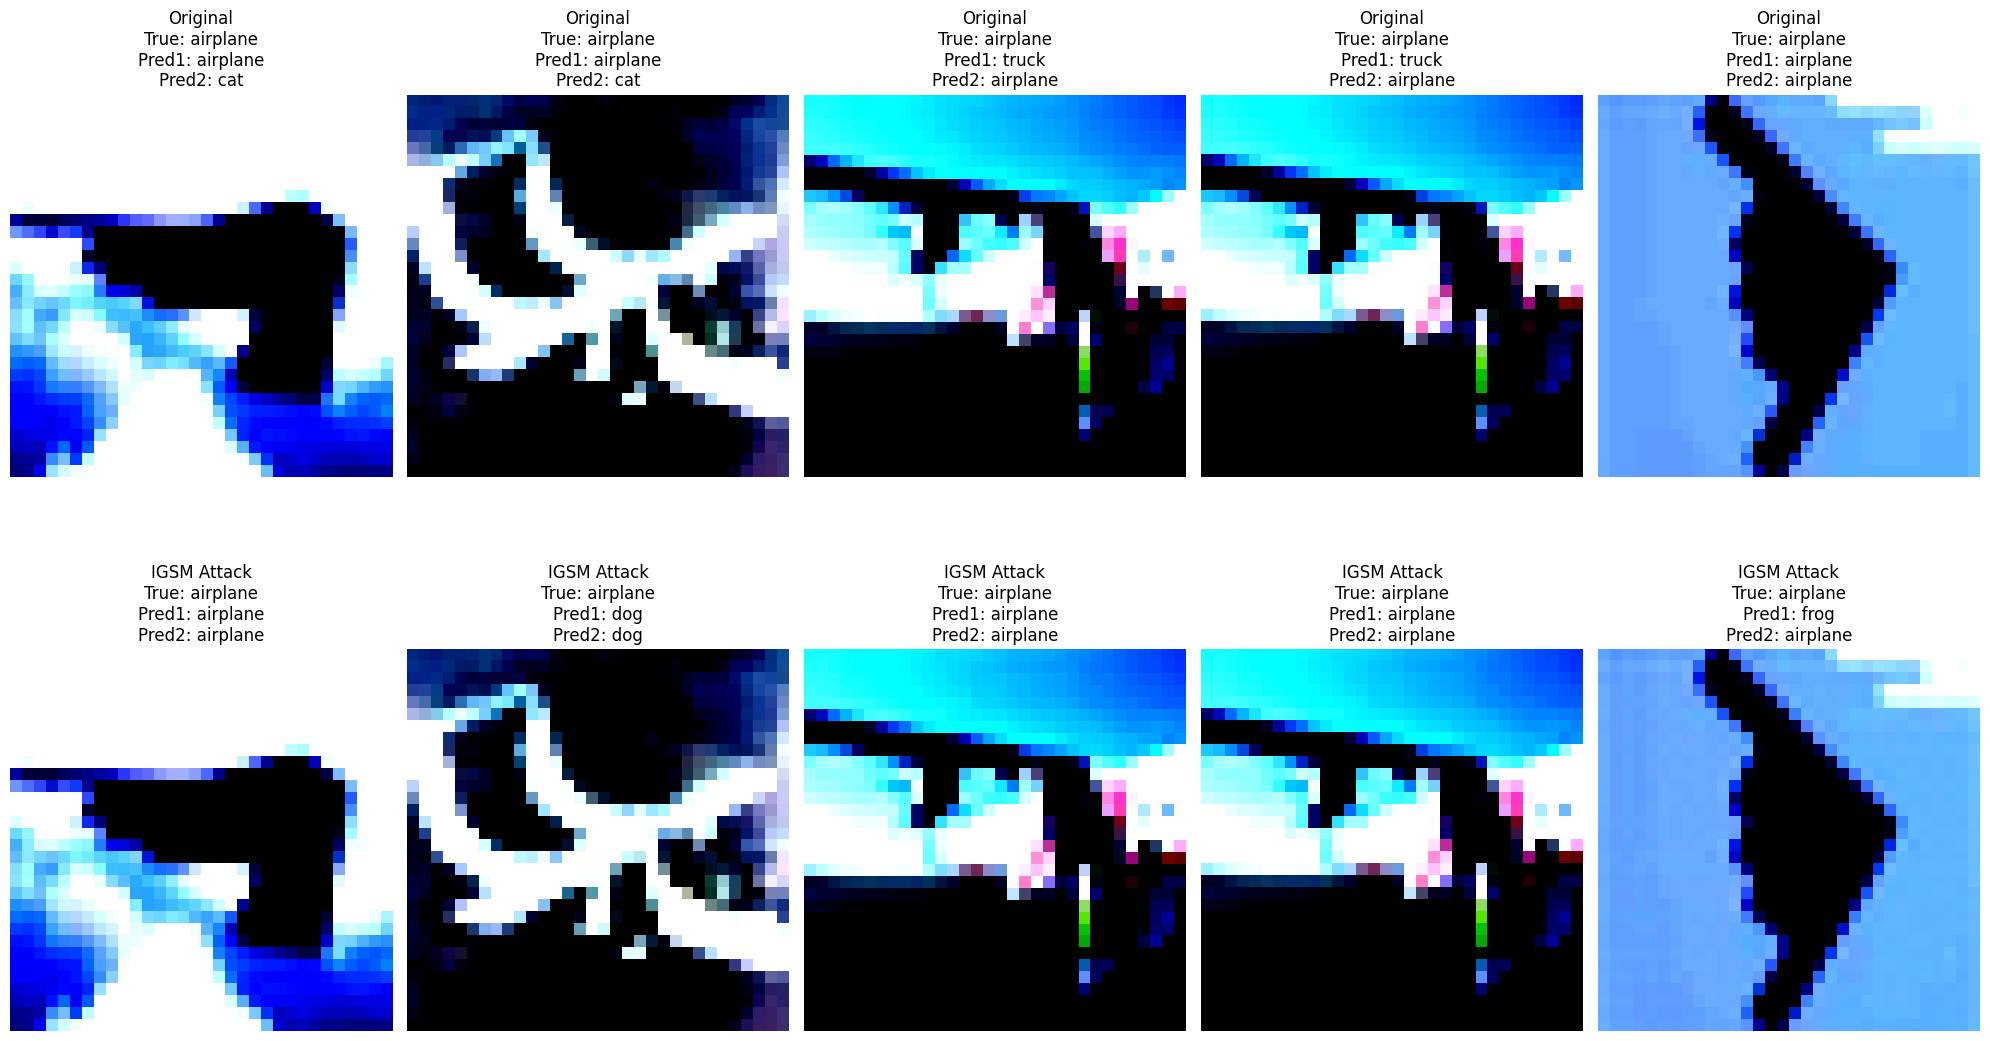

In [11]:
#@title Qualitative analysis

resnet9o = ResNet9().to(device)
resnet9o.load_state_dict(torch.load('/content/drive/MyDrive/resnet9_pretrained.pth'))

resnet9_attack = ResNet9().to(device)
resnet9_attack.load_state_dict(torch.load('/content/drive/MyDrive/resnet9igsm_pretrained10.pth'))

categories = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def visualize_attack_comparison(model1, model2, data_loader, num_samples=5):
    model1.eval()
    model2.eval()

    fig, axes = plt.subplots(2, num_samples, figsize=(20, 12))
    sample_count = 0

    while sample_count < num_samples:
        images, labels = next(iter(data_loader))
        batch_size = images.size(0)

        idx = random.randint(0, batch_size - 1)

        image = images[idx:idx+1].to(device)
        label = labels[idx:idx+1].to(device)

        adv_image = igsm_attack(model1, image, label)

        # Original image
        original_pred1 = model1(image).argmax().item()
        original_pred2 = model2(image).argmax().item()

        # Attacked image
        adv_pred1 = model1(adv_image).argmax().item()
        adv_pred2 = model2(adv_image).argmax().item()

        # Check if there's a difference in predictions
        if original_pred1 != adv_pred1 or original_pred2 != adv_pred2 or adv_pred1 != adv_pred2:

            axes[0, sample_count].imshow(image.cpu().squeeze().permute(1, 2, 0))
            axes[0, sample_count].axis('off')
            axes[0, sample_count].set_title(f'Original\nTrue: {categories[label.item()]}\nPred1: {categories[original_pred1]}\nPred2: {categories[original_pred2]}')

            axes[1, sample_count].imshow(adv_image.cpu().squeeze().permute(1, 2, 0).detach())
            axes[1, sample_count].axis('off')
            axes[1, sample_count].set_title(f'IGSM Attack\nTrue: {categories[label.item()]}\nPred1: {categories[adv_pred1]}\nPred2: {categories[adv_pred2]}')

            sample_count += 1

    plt.tight_layout()
    plt.show()

# Set random seed for reproducibility
# random.seed(42)
# torch.manual_seed(42)

# Visualize IGSM attack images for both models
print("IGSM Attack Images Comparison:")
visualize_attack_comparison(resnet9o, resnet9_attack, test_loader)